In [ ]:
import yfinance as yf
import pandas as pd

with open('/content/sample_data/Natixis stock (dataset TD1&2).txt', 'r') as file:
  lines = file.readlines()


dates =[]
prices = []

for line in lines:
  line=line.strip()
  if line:
    date,price= line.split('\t')
    dates.append(date)
    prices.append(price)

d = {'Date':dates, 'Price':prices}
df=pd.DataFrame(d)

df['Price']= df['Price'].str.replace(',','.').astype(float)
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df.set_index('Date', inplace=True)

returns =[]
for i in range(1,len(df)):
  price_yesterday= df['Price'][i-1]
  price_today = df['Price'][i]
  returns.append((price_today-price_yesterday)/price_yesterday)

df['Price Returns'] =  [None] + returns
df = df.iloc[1:]

Calculons la GEV avec l'estimateur de Pickands 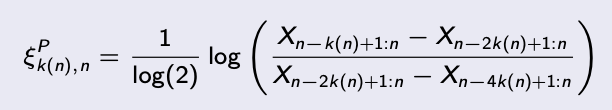

Pour la foncton k(n) on prends log qui verifie bien les conditions pour l'estimateur de pickands.

In [ ]:
import math as m
import numpy as np

sorted_returns = df.sort_values(by='Price Returns', ascending=True)
returns_negative= sorted_returns[sorted_returns['Price Returns']<0]*(-1) # On prends la queue de distribution des pertes, on multiplie par -1 pr les avoirs en positif
returns_negative = returns_negative.sort_values(by='Price Returns', ascending=True)

returns_positive= sorted_returns[sorted_returns['Price Returns'] > 0]


def estimateur_pickands(return_sort):
  n = len(return_sort)#revoir les indexs
  index_1 = n - int(np.log(n))+1
  index_2 = n - int(2 * np.log(n))+1
  index_4 = n - int(4 * np.log(n))+1

  pickands = (1 / np.log(2)) * np.log((return_sort.iloc[index_1]['Price Returns'] - return_sort.iloc[index_2]['Price Returns'])
  / (return_sort.iloc[index_2]['Price Returns'] - return_sort.iloc[index_4]['Price Returns']))

  return pickands

gev_rend_positive = estimateur_pickands(returns_positive)
gev_rend_neg = estimateur_pickands(returns_negative)

print("GEV Paremeters for positive returns : ", gev_rend_positive)
print("GEV Parameters for negative returns : ", gev_rend_neg)

GEV Paremeters for positive returns :  0.7031608888285327
GEV Parameters for negative returns :  -0.5025788568345055


**Question 2**

In [ ]:
def Var_EVT(r,esti,alpha,k=1):
  n=len(r)
  A=(k/(n*(1-alpha)))**esti - 1
  B=(1 - 2**-esti)
  return (A/B)*(r[n-k-1]- r[n-2*k-1])+r[n-k-1]

VaR_EVT_Pickands2= Var_EVT(returns_negative['Price Returns'],gev_rend_positive,0.80)
print("\n The VaR EVT for Pickands with 80% condifence for negative returns is : ",VaR_EVT_Pickands2)

VaR_EVT_Pickands4= Var_EVT(returns_negative['Price Returns'],gev_rend_positive,0.90)
print("\n The VaR EVT for Pickands with 90% condifence for negative returns is : ",VaR_EVT_Pickands4)

VaR_EVT_Pickands= Var_EVT(returns_negative['Price Returns'],gev_rend_positive,0.95)
print("\n The VaR EVT for Pickands with 95% condifence for negative returns is : ",VaR_EVT_Pickands)

VaR_EVT_Pickands3= Var_EVT(returns_negative['Price Returns'],gev_rend_positive,0.99)
print("\n The VaR EVT for Pickands with 99% condifence for negative returns is : ",VaR_EVT_Pickands3)



 The VaR EVT for Pickands with 80% condifence for negative returns is :  0.05473470769955061

 The VaR EVT for Pickands with 90% condifence for negative returns is :  0.05509283170307416

 The VaR EVT for Pickands with 95% condifence for negative returns is :  0.05567588190515239

 The VaR EVT for Pickands with 99% condifence for negative returns is :  0.05885113345175085
